In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import datetime as dt
import requests

In [2]:
#####################
##### PROBLEM 1 #####
#####################

In [3]:
##############
### Task 1 ###
##############

In [3]:
# reading the datasets
graffiti = pd.read_csv('311_Service_Requests_-_Graffiti_Removal.csv')
abandon = pd.read_csv('311_Service_Requests_-_Vacant_and_Abandoned_Buildings_Reported.csv')[1:]
pothole = pd.read_csv('311_Service_Requests_-_Pot_Holes_Reported.csv')
sanitation = pd.read_csv('311_Service_Requests_-_Sanitation_Code_Complaints.csv')[1:]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# sync column names to lower case 
graffiti.columns = [x.lower() for x in graffiti.columns]
abandon.columns = [x.lower() for x in abandon.columns]
pothole.columns = [x.lower() for x in pothole.columns]
sanitation.columns = [x.lower() for x in sanitation.columns]

In [6]:
# cleaning up column names, preparing to merge dataframes - Abandoned Building
abandon['street address'] = abandon['address street number'].map(str) +' '+ abandon['address street direction'] +' '+ abandon['address street name'] +' '+ abandon['address street suffix'] 
abandon.drop(['address street number', 'address street direction', 'address street name', 'address street suffix'], axis = 1, inplace = True)
abandon = abandon.rename(columns = {'service request type':'type of service request', 'date service request was received':'creation date'})

In [7]:
# cleaning up column names, preparing to merge dataframes - Potholes
pothole = pothole.rename(columns = {'zip':'zip code'})
pothole['type of service request'].replace('Pot Hole in Street', 'Pothole in Street', inplace = True)

In [8]:
# merging datasets to one 'complaints' datasets
complaints = pd.concat([graffiti, abandon, pothole, sanitation])

In [6]:
complaints.columns

Index(['any people using property? (homeless, childen, gangs)',
       'community area', 'completion date', 'creation date',
       'current activity',
       'if the building is open, where is the entry point?',
       'is building open or boarded?',
       'is the building currently vacant or occupied?',
       'is the building dangerous or hazardous?',
       'is the building vacant due to fire?', 'latitude', 'location',
       'location of building on the lot (if garage, change type code to bgd).',
       'longitude', 'most recent action', 'number of potholes filled on block',
       'police district', 'service request number', 'ssa', 'status',
       'street address', 'type of service request', 'ward',
       'what is the nature of this code violation?',
       'what type of surface is the graffiti on?',
       'where is the graffiti located?', 'x coordinate', 'y coordinate',
       'zip code'],
      dtype='object')

In [9]:
# Cleaning: Transforming dates in to datetime type
complaints['creation date'] = pd.to_datetime(complaints['creation date'], format = '%m/%d/%Y')
complaints['completion date'] = pd.to_datetime(complaints['completion date'], format = '%m/%d/%Y')
complaints = complaints[complaints['creation date'] >= '2013-01-01']

In [10]:
# Deleting all the duplicated entries from graffiti, 
complaints = complaints[((complaints['status'].str.contains('Dup')) & (complaints['status'] != None)) == False]

In [11]:
# Merging neighborhood data to the complaints data frame
complaints['community area'] = complaints['community area'].fillna(0.0).astype(int).astype(str)
neigh = pd.read_csv('CommAreas.csv')
neigh['community area'] = neigh['community area'].fillna(0.0).astype(int).astype(str)
complaints = complaints.merge(neigh, how = 'left')

In [12]:
# Creating response time 
complaints['response time'] = complaints['completion date'] - complaints['creation date']
complaints['response time flt'] = complaints['response time'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)

In [13]:
complaints[:10]

,"any people using property? (homeless, childen, gangs)",community area,completion date,creation date,current activity,"if the building is open, where is the entry point?",is building open or boarded?,is the building currently vacant or occupied?,is the building dangerous or hazardous?,is the building vacant due to fire?,...,what is the nature of this code violation?,what type of surface is the graffiti on?,where is the graffiti located?,x coordinate,y coordinate,zip code,neighborhood,sides,response time,response time flt
0,NaN,22,2013-01-02,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Brick - Unpainted,Rear,1.154077e+06,1.917986e+06,60647.0,LOGAN SQUARE,NORTH SIDE,1 days,1.0
1,NaN,22,2013-01-02,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Brick - Unpainted,Front,1.155556e+06,1.912793e+06,60647.0,LOGAN SQUARE,NORTH SIDE,1 days,1.0
2,NaN,21,2013-01-02,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Metal - Painted,Garage,1.152514e+06,1.920277e+06,60618.0,AVONDALE,NORTH SIDE,1 days,1.0
3,NaN,22,2013-01-02,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Metal - Painted,Garage,1.152253e+06,1.917729e+06,60647.0,LOGAN SQUARE,NORTH SIDE,1 days,1.0
4,NaN,62,2013-01-02,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Metal - Painted,Sign,1.147631e+06,1.867769e+06,60629.0,WEST ELSDON,SOUTHWEST SIDE,1 days,1.0
5,NaN,22,2013-01-02,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Aluminum Siding,Garage,1.155194e+06,1.912810e+06,60647.0,LOGAN SQUARE,NORTH SIDE,1 days,1.0
6,NaN,19,2013-01-02,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Wood - Painted,Rear,1.134278e+06,1.917382e+06,60639.0,BELMONT CRAGIN,NORTHWEST SIDE,1 days,1.0
7,NaN,70,2013-01-02,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Brick - Unpainted,Garage,1.148812e+06,1.847828e+06,60652.0,ASHBURN,FAR SOUTHWEST SIDE,1 days,1.0
8,NaN,59,2013-01-02,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"Cement (Sidewalk, Alley, Wall, Curb)",Alley,1.166191e+06,1.883381e+06,60608.0,MCKINLEY PARK,SOUTHWEST SIDE,1 days,1.0
9,NaN,14,2013-01-03,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Brick - Unpainted,Side,1.152517e+06,1.931678e+06,60625.0,ALBANY PARK,FAR NORTH SIDE,2 days,2.0


In [14]:
abd = complaints[complaints['type of service request'] == 'Vacant/Abandoned Building']
gft = complaints[complaints['type of service request'] == 'Graffiti Removal']
pth = complaints[complaints['type of service request'] == 'Pothole in Street']
snt = complaints[complaints['type of service request'] == 'Sanitation Code Violation']

In [15]:
##############
### Task 2 ###
##############

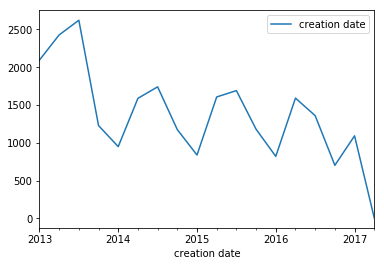

In [16]:
# Abandoned Building: Quarterly trends
d_abd = (abd['creation date']).to_frame()
d_abd.index = d_abd['creation date']
d_abd = d_abd.resample('Q').count()
d_abd.plot()

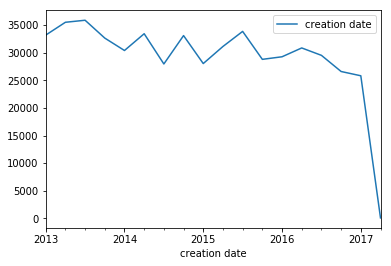

In [17]:
# Graffiti Removal: Quarterly trends
d_gft = (gft['creation date']).to_frame()
d_gft.index = d_gft['creation date']
d_gft = d_gft.resample('Q').count()
d_gft.plot()

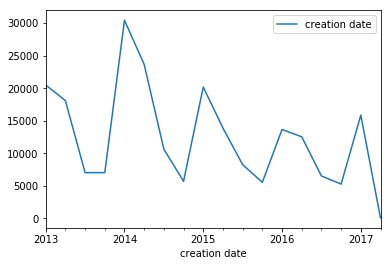

In [18]:
# Potholes: Quarterly trends
d_pth = (pth['creation date']).to_frame()
d_pth.index = d_pth['creation date']
d_pth = d_pth.resample('Q').count()
d_pth.plot()

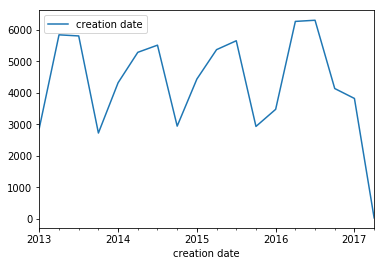

In [19]:
# Sanitation: Quarterly trends
d_snt = (snt['creation date']).to_frame()
d_snt.index = d_snt['creation date']
d_snt = d_snt.resample('Q').count()
d_snt.plot()

In [20]:
# All Service Request: Quarterly Summary Statistics
d_all = pd.concat([d_gft, d_abd, d_pth, d_snt], axis = 1)
heads = ['graffiti', 'abandoned', 'potholes', 'sanitation']
d_all.columns = heads
d_all.describe()

,graffiti,abandoned,potholes,sanitation
count,18.000000,18.000000,18.000000,18.000000
mean,29214.166667,1372.444444,12490.388889,4318.722222
std,7833.677615,634.295832,7791.190501,1632.497286
min,82.000000,6.000000,83.000000,30.000000
25%,28213.500000,984.750000,6651.500000,3076.250000
50%,30617.000000,1293.500000,11581.500000,4378.500000
75%,33148.500000,1669.000000,17533.250000,5617.000000
max,35863.000000,2621.000000,30425.000000,6303.000000


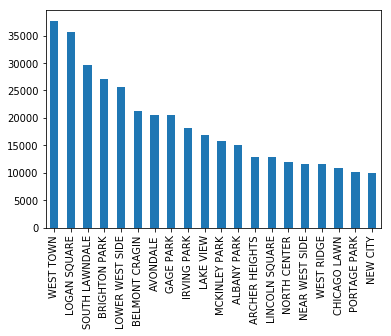

In [21]:
# Graffiti Removal: Top 20 neighborhoods reported 
n_gft = gft['neighborhood'].value_counts()
n_gft[:20].plot(kind = 'bar')

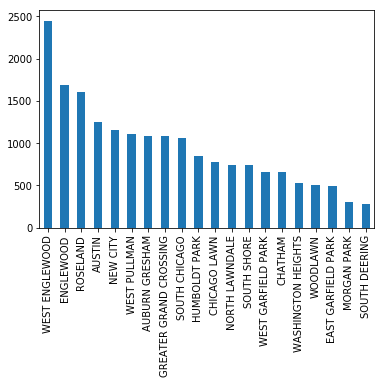

In [22]:
# Abandoned Buildings: Top 20 neighborhoods reported 
n_abd = abd['neighborhood'].value_counts()
n_abd[:20].plot(kind = 'bar')

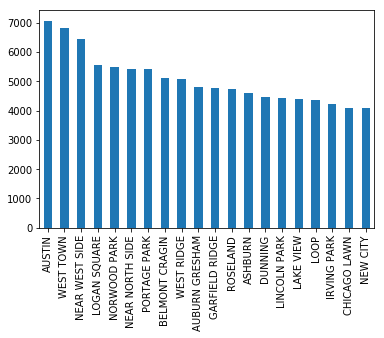

In [23]:
# Potholes: Top 20 neighborhoods reported 
n_pth = pth['neighborhood'].value_counts()
n_pth[:20].plot(kind = 'bar')

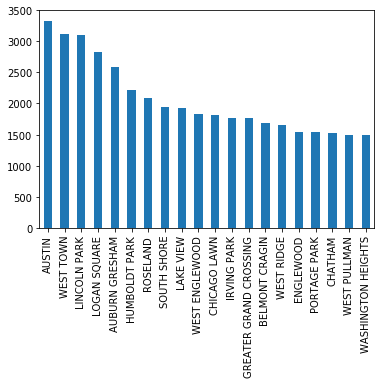

In [25]:
# Sanitation: Top 20 neighborhoods reported 
n_snt = snt['neighborhood'].value_counts()
n_snt[:20].plot(kind = 'bar')

In [26]:
# All Service Request: Summarry Statistics by neighborhood
n_all = pd.concat([n_gft, n_abd, n_pth, n_snt], axis = 1)
n_all.columns = heads
n_all.describe()

,graffiti,abandoned,potholes,sanitation
count,77.000000,77.000000,77.000000,77.000000
mean,6825.935065,320.636364,2911.246753,1009.532468
std,8682.795035,461.955708,1582.137704,771.895336
min,61.000000,2.000000,336.000000,52.000000
25%,627.000000,46.000000,1771.000000,386.000000
50%,2856.000000,115.000000,2694.000000,855.000000
75%,9903.000000,277.000000,4069.000000,1488.000000
max,37737.000000,2447.000000,7070.000000,3331.000000


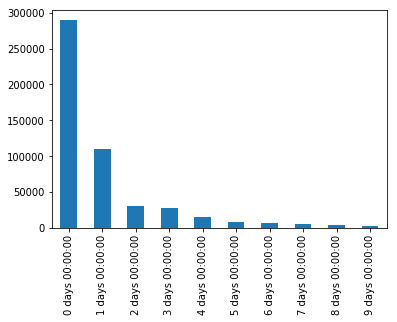

In [27]:
# Graffiti Removal: 10 Most typical response time 
r_gft = gft['response time'].value_counts()
r_gft[:10].plot(kind = 'bar')

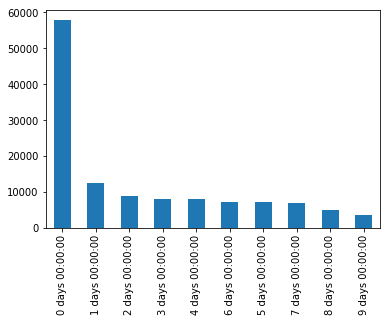

In [28]:
# Potholes: 10 Most typical response time 
r_pth = pth['response time'].value_counts()
r_pth[:10].plot(kind = 'bar')

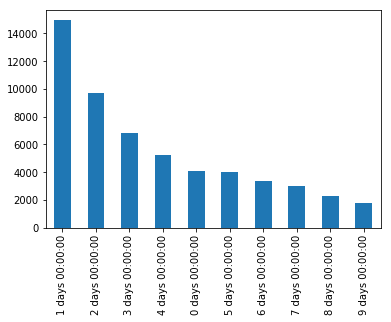

In [29]:
# Sanitation: 10 Most typical response time 
r_snt = snt['response time'].value_counts()
r_snt[:10].plot(kind = 'bar')

In [30]:
# All Service Request: Summarry Statistics by response time 
r_all = pd.concat([r_gft, r_pth, r_snt], axis = 1)
r_heads = ['graffiti', 'potholes', 'sanitation']
r_all.columns = r_heads
r_all.describe()

,graffiti,potholes,sanitation
count,202.000000,293.000000,154.000000
mean,2602.217822,763.764505,503.474026
std,21905.350044,3633.867346,1676.947839
min,1.000000,1.000000,1.000000
25%,3.000000,10.000000,4.000000
50%,21.000000,107.000000,19.000000
75%,142.750000,480.000000,224.750000
max,289333.000000,57729.000000,14929.000000


In [31]:
###### SUBTYPES ######

In [32]:
###### 1. GRAFFITI ######

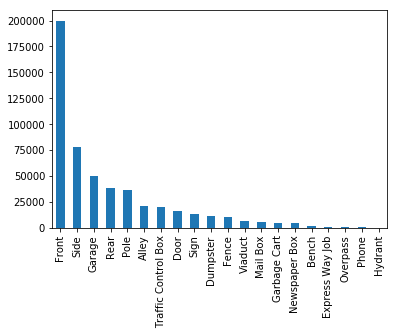

In [33]:
# Graffiti Location 
gft_location = gft['where is the graffiti located?'].value_counts()
gft_location.plot(kind = 'bar')

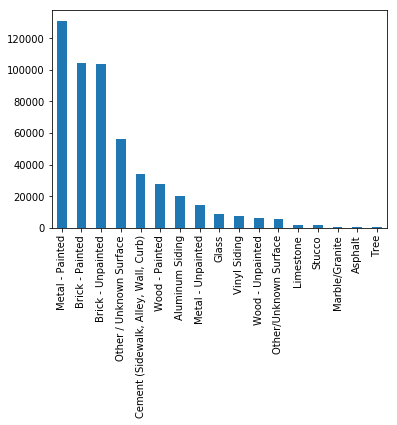

In [34]:
# Graffiti Surface 
gft_surface = gft['what type of surface is the graffiti on?'].value_counts()
gft_surface.plot(kind = 'bar')

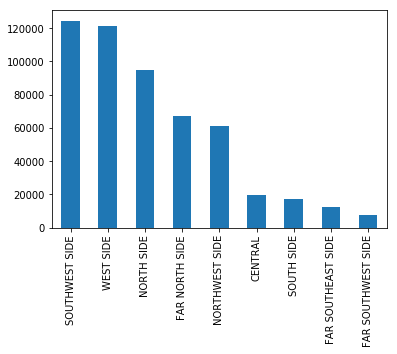

In [35]:
# Graffiti Location - Chicago Sides
gft_side = gft['sides'].value_counts()
gft_side.plot(kind = 'bar')

In [36]:
###### 2. ABANDONED BUILDINGS ######

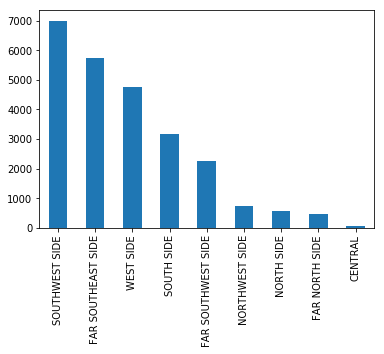

In [37]:
# Abandoned Building Location - Chicago Sides
abd_side = abd['sides'].value_counts()
abd_side.plot(kind = 'bar')

In [38]:
###### 3. POTHOLES ######

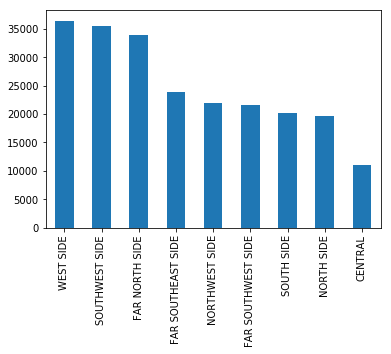

In [39]:
# Potholes Location - Chicago Sides
pth_side = pth['sides'].value_counts()
pth_side.plot(kind = 'bar')

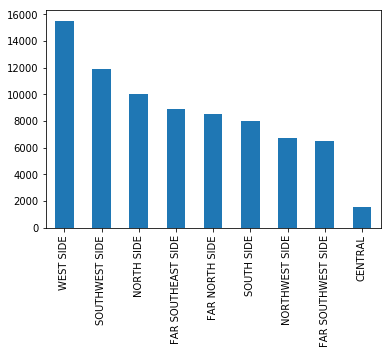

In [40]:
###### 4. SANITATION VIOLATION ######
snt_side = snt['sides'].value_counts()
snt_side.plot(kind = 'bar')

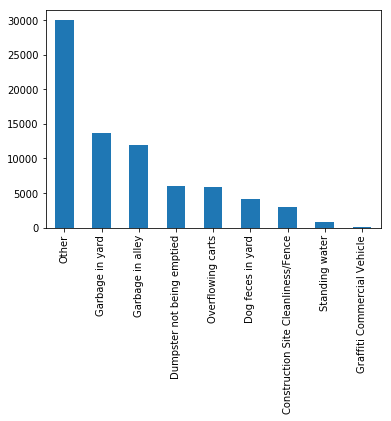

In [41]:
# Type of Sanitation Violation 
snt_type = snt['what is the nature of this code violation?'].value_counts()
snt_type.plot(kind = 'bar')

In [118]:
##############
### Task 3 ###
##############

# 5 Interesting observations about the Data Set:

# 1. Service requests are most frequently called from the West Side, Southwest Side, and Far Southeast Side
# 2. Decreasing trends of reports on abandoned building over time from 2011 to 2017, might be caused by improvement in the economy
# 3. Cyclical trends of reports on potholes and sanitation violation, with the former usually peaked during winter months and the latter peaked in the spring/summer months
# 4. Top number of reports for different types came from similar set of neighborhood
# 5. The suburbs are more likely to report a service request than those in the inner city 

In [43]:
#####################
##### PROBLEM 2 #####
#####################

In [44]:
### Task 1 ###

In [72]:
# Last 1 month of the Abandoned Buildings DF (Sample)
abd_last = abd[abd['creation date'] >= '2017-03-15']

In [73]:
# Last 1 month of the Abandoned Buildings DF (Sample)
snt_last = snt[snt['creation date'] >= '2017-03-15']

In [50]:
# Function to add FIPS column to the dataframe
def get_fips(lat, lon):
    api_url = 'https://www.broadbandmap.gov/broadbandmap/census/tract?latitude={}&longitude={}&format=json'.format(lat, lon)
    api_result = requests.get(api_url)
    
    if not api_result:
        return 
    api_json = api_result.json()
    fips = api_json['Results']['censusTract'][0]['fips']
    return fips

In [74]:
# Adding FIPS column to the dataframes
abd_last['fips'] = abd_last.apply(lambda row: get_fips(row['latitude'], row['longitude']), axis=1)
snt_last['fips'] = snt_last.apply(lambda row: get_fips(row['latitude'], row['longitude']), axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [48]:
# Function to request API
API_KEY = '4b9589e48b2c133ea08536dc2e7e72af1f66fa56'
QUERY = 'B01003_001E,B02001_002E,B02001_003E,B03001_003E,B19013_001E,B19301_001E,B01002_001E,B05002_013E'
RESULT_HEADER = ['total population', 'race - white', 'race - black', 'race - hispanic', 'median hhi', 'per capita income', 'median age', 'foreign born', 'state', 'county', 'tract']

def get_data(fkey, result_list):
    result_nan = [None]*len(RESULT_HEADER)
    if not fkey:
        return
    
    TRACT_FIPS = fkey[5:]
    api_url = 'http://api.census.gov/data/2011/acs5?get={}&for=tract:{}&in=state:17+county:031&key={}'.format(QUERY, TRACT_FIPS, API_KEY)
    api_result = requests.get(api_url)
    api_json = api_result.json()
    
    if api_json not in result_list:  
        result_list += [api_json[1]]

In [49]:
# Function to call & query Census API
def get_api_request(fips_srs):
    result_list = []
    result_list += [RESULT_HEADER]
    
    for fkey in fips_srs:
        get_data(fkey, result_list)
        #print(result_list)
    return result_list

In [51]:
# Calling Census API
abd_api_call = get_api_request(abd_last['fips'])
snt_api_call = get_api_request(snt_last['fips'])

In [52]:
# Removing header row
abd_headers = abd_api_call.pop(0)
snt_headers = snt_api_call.pop(0)

In [54]:
# Create api Data Frame
abd_api_df = pd.DataFrame(abd_api_call, columns= abd_headers)
snt_api_df = pd.DataFrame(snt_api_call, columns= snt_headers)

In [55]:
# Cleaning: Preparing 'fips' as merging key 
abd_api_df['fips'] = abd_api_df['state']+ abd_api_df['county'] + abd_api_df['tract']
snt_api_df['fips'] = snt_api_df['state']+ snt_api_df['county'] + snt_api_df['tract']

In [56]:
# Cleaning: Converting string to numeric columns 
api_dfs = [abd_api_df, snt_api_df]
api_num_hdr = RESULT_HEADER[:-3]

for df in api_dfs:
    for hdr in api_num_hdr:
        df[hdr] = pd.to_numeric(df[hdr])

In [120]:
# Merging API data to the sample df
abd_last = abd_last.merge(abd_api_df, how = 'left', on = 'fips').drop_duplicates()
snt_last = snt_last.merge(snt_api_df, how = 'left', on = 'fips').drop_duplicates()

In [121]:
abd_last[:10]

,"any people using property? (homeless, childen, gangs)",community area,completion date,creation date,current activity,"if the building is open, where is the entry point?",is building open or boarded?,is the building currently vacant or occupied?,is the building dangerous or hazardous?,is the building vacant due to fire?,...,race - white_y,race - black_y,race - hispanic_y,median hhi_y,per capita income_y,median age_y,foreign born_y,state_y,county_y,tract_y
0,False,44,NaT,2017-03-15,NaN,NaN,Open,Vacant,NaN,False,...,30,2771,12,47315,20872,36.5,0,17,031,440900
2,False,69,NaT,2017-03-15,NaN,NaN,Open,Vacant,NaN,False,...,34,4242,39,34267,18610,39.1,0,17,031,690900
5,False,68,NaT,2017-03-15,NaN,NaN,Open,Vacant,NaN,False,...,8,2896,0,25313,16240,33.8,0,17,031,681400
11,False,67,NaT,2017-03-15,NaN,NaN,Open,Vacant,NaN,False,...,59,1718,44,38170,14477,37.9,44,17,031,671400
12,False,71,NaT,2017-03-15,NaN,NaN,Open,Vacant,NaN,False,...,0,1737,0,23418,11518,30.1,75,17,031,710300
14,False,67,NaT,2017-03-15,NaN,NaN,Open,Vacant,NaN,False,...,121,3797,108,28092,10316,28.1,88,17,031,671500
19,False,68,NaT,2017-03-16,NaN,NaN,Open,Vacant,NaN,False,...,0,1362,0,14085,8699,39.0,0,17,031,680600
20,False,66,NaT,2017-03-15,NaN,NaN,Open,Vacant,NaN,False,...,309,4010,307,31685,12953,31.2,410,17,031,660900
23,False,43,NaT,2017-03-16,NaN,NaN,Open,Vacant,NaN,False,...,85,2138,49,31250,22382,35.0,48,17,031,430700
24,NaN,29,NaT,2017-03-16,NaN,NaN,NaN,NaN,NaN,NaN,...,139,4027,139,22833,10678,25.1,57,17,031,290900


,"any people using property? (homeless, childen, gangs)",community area,completion date,creation date,current activity,"if the building is open, where is the entry point?",is building open or boarded?,is the building currently vacant or occupied?,is the building dangerous or hazardous?,is the building vacant due to fire?,...,race - white_y,race - black_y,race - hispanic_y,median hhi_y,per capita income_y,median age_y,foreign born_y,state_y,county_y,tract_y
0,False,68,NaT,2017-03-15,NaN,NaN,Open,Vacant,NaN,False,...,8,2896,0,25313,16240,33.8,0,17,031,681400
1,False,67,NaT,2017-03-15,NaN,NaN,Open,Vacant,NaN,False,...,121,3797,108,28092,10316,28.1,88,17,031,671500
2,False,46,NaT,2017-03-21,NaN,NaN,Open,Vacant,NaN,False,...,975,1738,1748,22753,8072,20.9,825,17,031,460700
3,False,46,NaT,2017-03-21,NaN,NaN,Open,Vacant,NaN,False,...,975,1738,1748,22753,8072,20.9,825,17,031,460700
4,False,46,NaT,2017-03-21,NaN,NaN,Open,Vacant,NaN,False,...,975,1738,1748,22753,8072,20.9,825,17,031,460700
5,False,46,NaT,2017-03-21,NaN,NaN,Open,Vacant,NaN,False,...,975,1738,1748,22753,8072,20.9,825,17,031,460700
6,False,46,NaT,2017-03-21,NaN,NaN,Boarded,Vacant,NaN,False,...,975,1738,1748,22753,8072,20.9,825,17,031,460700
7,False,69,NaT,2017-03-17,NaN,NaN,Open,Vacant,NaN,False,...,0,2407,0,31680,22599,30.9,9,17,031,691200
8,False,69,NaT,2017-03-20,NaN,NaN,Boarded,Vacant,NaN,False,...,0,2407,0,31680,22599,30.9,9,17,031,691200
9,True,69,NaT,2017-03-20,NaN,ALL OVER,Open,Vacant,NaN,False,...,0,2407,0,31680,22599,30.9,9,17,031,691200


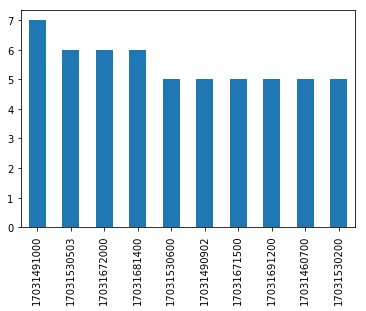

In [122]:
abdl_cnt = abd_last['fips'].value_counts()
abdl_cnt[:10].plot(kind = 'bar')
abd_list = list(abdl_cnt[:10].index)
abd_char = abd_last[abd_last['fips'].isin(abd_list)].reset_index(drop=True)
abd_char

,"any people using property? (homeless, childen, gangs)",community area,completion date,creation date,current activity,"if the building is open, where is the entry point?",is building open or boarded?,is the building currently vacant or occupied?,is the building dangerous or hazardous?,is the building vacant due to fire?,...,race - white,race - black,race - hispanic,median hhi,per capita income,median age,foreign born,state,county,tract
0,False,68,NaT,2017-03-15,NaN,NaN,Open,Vacant,NaN,False,...,8.0,2896.0,0.0,25313.0,16240.0,33.8,0.0,17,031,681400
1,False,67,NaT,2017-03-15,NaN,NaN,Open,Vacant,NaN,False,...,121.0,3797.0,108.0,28092.0,10316.0,28.1,88.0,17,031,671500
2,False,46,NaT,2017-03-21,NaN,NaN,Open,Vacant,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,False,46,NaT,2017-03-21,NaN,NaN,Open,Vacant,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,False,46,NaT,2017-03-21,NaN,NaN,Open,Vacant,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,False,46,NaT,2017-03-21,NaN,NaN,Open,Vacant,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,False,46,NaT,2017-03-21,NaN,NaN,Boarded,Vacant,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,False,69,NaT,2017-03-17,NaN,NaN,Open,Vacant,NaN,False,...,0.0,2407.0,0.0,31680.0,22599.0,30.9,9.0,17,031,691200
8,False,69,NaT,2017-03-20,NaN,NaN,Boarded,Vacant,NaN,False,...,0.0,2407.0,0.0,31680.0,22599.0,30.9,9.0,17,031,691200
9,True,69,NaT,2017-03-20,NaN,ALL OVER,Open,Vacant,NaN,False,...,0.0,2407.0,0.0,31680.0,22599.0,30.9,9.0,17,031,691200


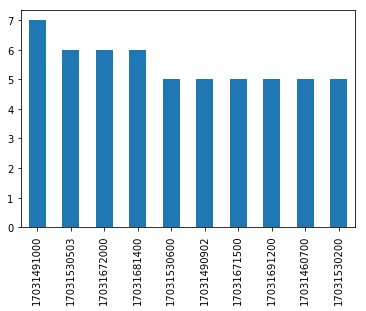

In [124]:
sntl_cnt = snt_last['fips'].value_counts()
sntl_cnt[:10].plot(kind = 'bar')
snt_list = list(sntl_cnt[:10].index)
snt_char = snt_last[snt_last['fips'].isin(snt_list)].reset_index(drop=True)
snt_char

In [ ]:
#### POLICY WRITING ####
'''
Observations:
1. Tracts who are more likely to call for service request have a comparatively bigger population of black/african american, sometime they are the only population
2. Income are relatively low in the area of concerns, with median HHI ranging from 25k to 50k

The available census data did not allow us to examine the changes in the neighborhood characteristics overtime.

'''

In [ ]:
#####################
##### PROBLEM 3 #####
#####################

In [192]:
##### TASK 1 #####

In [225]:
# Probability of a call from 7500 S Wolcott Ave (AUBURN GRESHAM - 71 Community Area)
call_df = complaints[complaints['community area'] == '71']['type of service request'].value_counts().to_frame().reset_index()
call_df = call_df.rename(columns={'index' : "service request", 'type of service request': 'count'})
call_df['probability'] = call_df['count']/sum(call_df['count'])
call_df

,service request,count,probability
0,Pothole in Street,6592,0.474484
1,Sanitation Code Violation,3920,0.282156
2,Vacant/Abandoned Building,2207,0.158857
3,Graffiti Removal,1174,0.084503


In [226]:
##### TASK 2 #####

In [236]:
call2_df = gft[gft['neighborhood'].isin(['UPTOWN', 'NORTH LAWNDALE', 'SOUTH LAWNDALE'])]['neighborhood'].value_counts().to_frame().reset_index()
call2_df = call2_df.rename(columns={'index' : 'nbhood', 'neighborhood': 'count'})
call2_df['probability'] = call2_df['count']/sum(call2_df['count'])
call2_df

,nbhood,count,probability
0,SOUTH LAWNDALE,52434,0.776662
1,UPTOWN,10747,0.159187
2,NORTH LAWNDALE,4331,0.064152


In [238]:
likelihood = (0.776662+0.064152)/0.159187
likelihood

5.2819262879506494

In [ ]:
# Answer: The call is 5 times more likely to come from the LAWNDALE area than UPTOWN

In [234]:
##### TASK 3 #####

In [240]:
p_uptown = (260/1000)*(160/260)
p_uptown

0.16

In [241]:
p_englewood = (260/1000)*(100/260)
p_englewood

0.1

In [242]:
likelihood2 = p_uptown/p_englewood
likelihood

5.2819262879506494

In [ ]:
# Answer: It will be more likely for the call to come from UPTOWN